In [1]:
from astropy.table import Table
import numpy as np
import astropy.units as u
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from irf import power_law
%matplotlib inline

In [2]:
table = Table.read('./../irf/tests/test_files/cta_south_dc1.irf', hdu='EFFECTIVE AREA')

In [3]:
class EffectiveArea():
    
    def __init__(self, grid, data):
        self.grid = grid
        self.data = data
        self.interpolator = RegularGridInterpolator(grid, data, bounds_error=False)
    
    @u.quantity_input(energy=u.TeV, theta=u.deg)
    def evaluate(self, energy, theta):
        e = energy.to(grid[0].unit).value
        t = theta.to(grid[1].unit).value
        aeff = self.interpolator((e, t))
        return aeff * data.unit
    
    @property
    def max_energy(self):
        return self.grid[0].max()
        
    @property
    def min_energy(self):
        return self.grid[0].min()
    
    @property
    def max_offset(self):
        return self.grid[1].max()
        
    @property
    def min_offset(self):
        return self.grid[1].min()


def irf_from_table(table, colnames=None, interpolation_modes={}):
    # read table data that stores n-dimensional data in ogip convention
    # I haven't found any documents describing that standard. Im  sure its out there somewhere
    bounds = table.colnames[:-1]
    low_bounds = bounds[::2]
    high_bounds = bounds[1::2]

    data = table[table.colnames[-1]].quantity[0].T

    # we need to check this unit specifically because ctools writes weird units into fits tables
    # and astropy goes haywire. Juergen promised to fix this in the next release of the CTA irfs
    if data.unit == '1/s/MeV/sr':
        import astropy.units as u
        data = data.value * u.Unit('1/(s MeV sr)')

    if not colnames:
        colnames = [n.replace('_LO', '') for n in low_bounds]

    grid = []
    for colname_low, colname_high, name in zip(low_bounds, high_bounds, colnames):
        bins_low = np.ravel(table[colname_low]).quantity
        bins_high = np.ravel(table[colname_high]).quantity
        
        mode  = interpolation_modes.get(name, 'linear')
        
        if mode == 'linear':
            nodes = (bins_low + bins_high)/2
        elif mode == 'log':
            nodes  = np.sqrt(bins_low * bins_high)
        
        grid.append(nodes)

    return grid, data
    


In [4]:
CTA_SCATTER_RADIUS = 2500.0 * u.m
CTA_SCATTER_AREA = CTA_SCATTER_RADIUS**2 * np.pi
T_OBS = 1 * u.h


def expected_events_in_bins(index, bins):
    events_per_time_and_area = np.array([expected_events_in_range(index, m, n) for m, n in zip(bins[0:], bins[1:])])
    return events_per_time_and_area

def expected_events_in_range(index, e_low, e_high):
    return (1 / (index + 1)) * (e_high**(index + 1) - e_low**(index + 1))

def draw_samples(e_min, e_max, size, index):
    a = e_min.to('TeV').value**(index + 1)
    b = e_max.to('TeV').value**(index + 1)
    r = np.random.uniform(0, 1, size)
    k = (a + (b - a) * r)
    e = k**(1. / (index + 1))
    return e * u.TeV

def apply_acceptance(samples, aeff, offset=0.51*u.deg, scatter_radius=2500.0*u.m):
    scatter_area = scatter_radius**2 * np.pi
    trigger_probability = (aeff.evaluate(samples, theta=0.51*u.deg)/CTA_SCATTER_AREA).si.value
    m  = np.random.uniform(0, 1, size=len(samples)) < trigger_probability
    return samples[m]


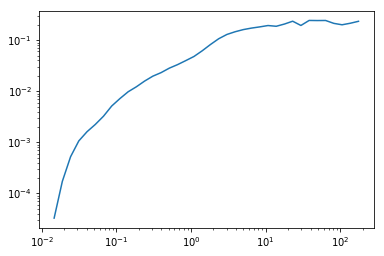

In [5]:
grid, data =  irf_from_table(table, interpolation_modes={'ENERG':'log'})
aeff = EffectiveArea(grid, data)

bins=np.logspace(-2, 2.3, 40, base=10)
bin_centers = np.sqrt(bins[0:-1] * bins[1:])

trigger_probability = (aeff.evaluate(bin_centers*u.TeV, theta=0.51*u.deg)/CTA_SCATTER_AREA).si.value
plt.plot(bin_centers, trigger_probability)
plt.xscale('log')
plt.yscale('log')


### Toy samples

perform a toy MC simulation to get some data. sample it from the crab spectrum.

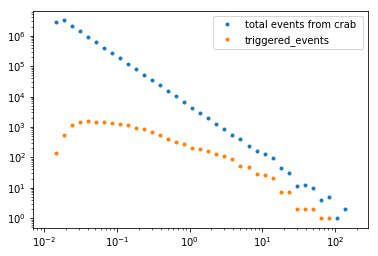

In [6]:
# Old MAGIC crab spectrum
N_crab = (2.83e-14 / (u.GeV * u.cm**2 * u.s)).to(1/(u.TeV * u.m**2 *u.h))
index_crab = -2.62

number_of_gammas_crab = expected_events_in_range(index_crab, aeff.min_energy.value, aeff.max_energy.value) * u.TeV * N_crab * T_OBS * CTA_SCATTER_AREA
number_of_gammas_crab = number_of_gammas_crab.si.value
samples = draw_samples(aeff.min_energy, aeff.max_energy, index=index_crab, size=int(number_of_gammas_crab))

triggered_events = apply_acceptance(samples, aeff, scatter_radius=CTA_SCATTER_RADIUS)

c_crab, _ = np.histogram(samples, bins=bins)
c_measured, _  = np.histogram(triggered_events, bins=bins)


plt.plot(bin_centers, c_crab, '.', label='total events from crab ')
plt.plot(bin_centers, c_measured, '.', label='triggered_events')
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Fold Model

Try and fold a model below. Predict counts per bin given some spectrum. should match simulation above for same spectral index and normailzation

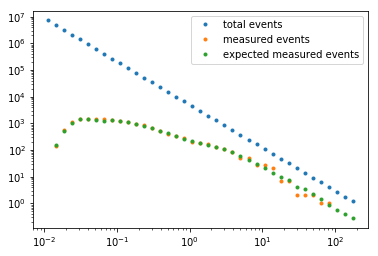

In [31]:

areas = aeff.evaluate(bin_centers * u.TeV, theta=0.6*u.deg)

expected_triggered_events = expected_events_in_bins(index=index_crab, bins=bins) * T_OBS * areas * N_crab * u.TeV
total_events = expected_events_in_bins(index=index_crab, bins=bins) * T_OBS * CTA_SCATTER_AREA * N_crab * u.TeV

plt.plot(bin_centers, total_events, '.', label='total events')
plt.plot(bin_centers, c_measured, '.', label='measured events')
plt.plot(bin_centers, expected_triggered_events, '.', label='expected measured events')
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Fitting
Define a likelihood function. Use (wrong) chi2 for now. then start MCMC sampling

In [8]:
def likelihood(p, c_measured, bins, areas, T_OBS):
    N, index = p

    if N < 0.0002 or N > 0.0035:
        return -np.inf
    if index < -4 or index > -1.0:
        return -np.inf 
    
    c_expected = expected_events_in_bins(index=index, bins=bins) * T_OBS * areas * N
    g = (c_expected - c_measured)**2 / c_expected
    g[g==np.inf] = 0
    g  = np.nan_to_num(g)
    chi_square = np.sum(g)
    return -0.5 * chi_square

In [17]:
# strip some units for speed
a = areas.to('m^2').value
t = T_OBS.value

In [18]:
%timeit likelihood((0.001, -2.62), c_measured, bins, a, t)

108 µs ± 3.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


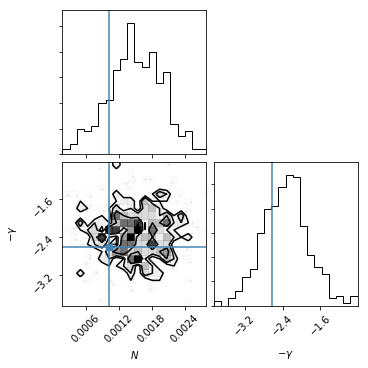

In [26]:
import corner
nwalkers = 400
ndim = 2 

range_n = [0.0001, 0.003]
range_index = [-2, -3]

p_a = np.random.normal(loc=0.0015, scale=0.0005, size=nwalkers) 
p_index = np.random.normal(loc=-2.3, scale=0.5,  size=nwalkers) 
p0 = np.vstack([p_a, p_index]).T

_ = corner.corner(p0, labels=['$N$', '$-\gamma$'], truths=[N_crab.value, index_crab], )

In [27]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood, args=[c_measured, bins, a, t], threads=4)
pos, prob, state = sampler.run_mcmc(p0, 50)
sampler.reset()
sampler.run_mcmc(pos, 200);
samples  = sampler.flatchain

/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


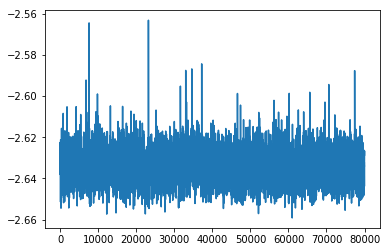

In [28]:
plt.plot(samples[:, 1])

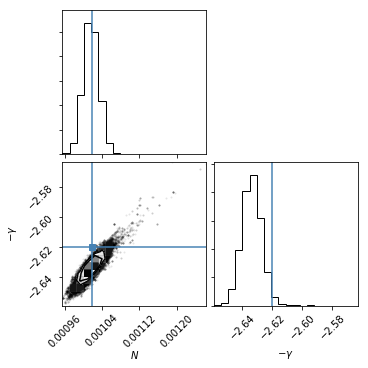

In [29]:
_ = corner.corner(samples,
                  labels=['$N$', '$-\gamma$'],
                  truths=[N_crab.value, index_crab],
#                   range=[range_n, range_index]
                 )

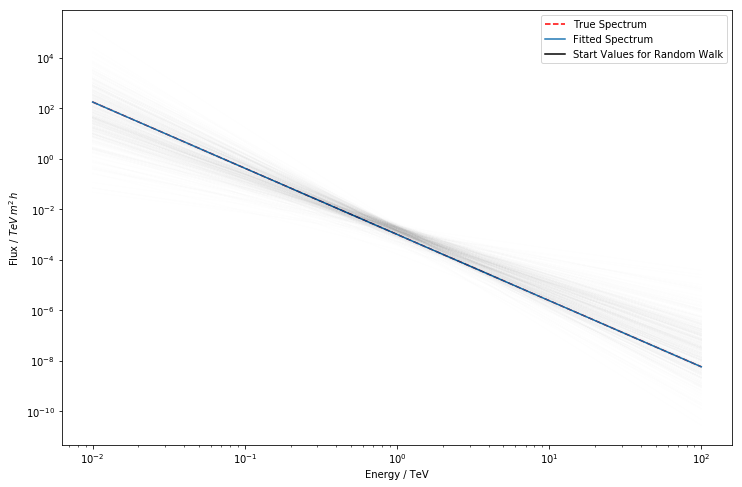

In [91]:
import matplotlib.lines as mlines



N_fit, index_fit = samples.mean(axis=0)

e = np.logspace(-2, 2, 50)
plt.figure(figsize=(12, 8))
h1, = plt.plot(e, N_crab * e **index_crab , '--', label='True Spectrum', color='red')
h2, = plt.plot(e, N_fit * e **(-2.62) , label='Fitted Spectrum')

for n, index in p0:
    plt.plot(e, n * e **index, color='black', alpha=0.0051)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy / TeV')
plt.ylabel('Flux / $TeV\, m^2\, h$')
plt.legend()
h3 = mlines.Line2D([], [], color='black', label='Start Values for Random Walk')
plt.legend(handles=[h1, h2, h3])


In [80]:
n_mcmc, index_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

from IPython.display import display, Math, Latex
print('Index:')
display(Math('{{{:6.3f}}}_{{{:6.4f}}}^{{{:6.4f}}}$'.format(*index_mcmc)))

print('Normalization:')
display(Math('{{{:0.5f}}}_{{{:0.6f}}}^{{{:0.6f}}}$'.format(*n_mcmc)))


Index:


<IPython.core.display.Math object>

Normalization:


<IPython.core.display.Math object>